In [38]:
import torch
import torch.nn.functional as F

dim = 1024
datatype = 'bipolar'
operation = 'MAP'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     torch.set_default_device(device=device)
# else:
#     print("CUDA is not avalable. Defaulting to CPU")
device

device(type='cuda')

# 随机数产生

## 1. 完全随机 

- CA 90 规则

In [39]:
def CA90(vec):
    """
    Function
    ===
    CA90 rule. Next = (vec << 1) ^ (vec >> 1) where input vectors are cylic shift.
    """
    vec_left = torch.roll(vec, shifts=-1, dims=0)
    vec_right = torch.roll(vec, shifts=1, dims=0)

    return vec_left ^ vec_right

In [3]:
def item_memory(dim, number, datatype):
    """
    Function
    ===
    Generate random vectors

    Parameter
    ---
    The size of the vectors is (number, dim)
    Data type must be 'bipolar' by now so that the element is within {-1, 1}

    """
    if datatype != 'bipolar':
        raise ValueError('Sorry, currently only supporting bipolar datatype.')
    table = torch.randint(low=0, high=2, size=(number, dim), dtype=torch.int8)
    table[table == 0] = -1
    return table

iM = item_memory(dim=dim, number=3, datatype=datatype)
iM, CA90(iM)

(tensor([[-1,  1, -1,  ...,  1, -1,  1],
         [ 1,  1, -1,  ..., -1, -1, -1],
         [-1, -1,  1,  ..., -1,  1, -1]], dtype=torch.int8),
 tensor([[-2, -2, -2,  ...,  0, -2,  0],
         [ 0, -2, -2,  ..., -2, -2, -2],
         [-2,  0,  0,  ..., -2,  0, -2]], dtype=torch.int8))

## 2. 连续级别的 HV CiM

## 3. 循环的 circlar

需要参考 torchhd 内的实现方法

In [4]:
import math

# MAP 操作
对于 {-1, 1}，硬件二值逻辑表示为 {0 -> -1, 1 -> 1}

- bind
+

- bundle


- permutation




In [5]:
def bind(hv1, hv2):
    """
    Function
    ===
    xor elementwise
    """    
    return hv1 * hv2

def bundle(hv1, hv2):
    """
    Function
    ===
    if the sum >= 1, set to 1
    else set to 0
    """
    #return hv1 + hv2
    return ((hv1 + hv2) > 0).int() * 2 - 1

def permutation(hv):
    """
    Function
    ===
    permutation the input vec
    right shift by 1 element
    """

    return hv.roll(hv, shifts=1, dims=0)

# 相似性度量

Hamming & cosine

In [5]:
def similarity(hv1, hv2, stype):
    if stype == 'cos':
        return F.cosine_similarity(hv1.float(), hv2.float(), dim=0)
    elif stype == 'ham':
        ham = hv1 ^ hv2
        return torch.sum(ham != 0)


In [5]:
v1 = torch.tensor([1, 1, 1]).to(torch.float)
v2 = torch.tensor(
    [[1, 1, 1],
     [1, -1, -1]]
).to(torch.float)
simi = F.cosine_similarity(v1, v2)
simi, torch.max(simi), torch.argmax(simi).dtype

(tensor([ 1.0000, -0.3333]), tensor(1.0000), torch.int64)

证明对于 bipolar {-1, 1} 来说，Hamming 和 cos 有线性关系
$$
cos(H_1, H_2) = 1 - 2/D_{hv} Hamming(H_1, H_2)
$$

In [6]:
vech1 = torch.randint(low=0, high=2, size=(dim, )) * 2 - 1
vech2 = torch.randint(low=0, high=2, size=(dim, )) * 2 - 1

cos_simi = similarity(vech1, vech2, stype='cos')
ham_simi = similarity(vech1, vech2, stype='ham')

cos_simi.item(), 1 - 2/dim * ham_simi.item(), ham_simi.item()

(-0.037109375, -0.037109375, 531)

热力图表示相似度

In [ ]:
number = 8
dimension = 1024
rand_vec = torch.randint(0, 2, (8, 1024)) * 2 - 1

In [ ]:
F.cosine_similarity(rand_vec.float(), rand_vec.float(), dim=1)

In [9]:
def inter_cos_simi(hvs1, hvs2, stype='cos'):

    """
    Function
    ===

    Parameter
    ---
    (n, dim) & (m, dim) vector

    Return
    ---
    matrix (n, m)
    """
    dot_product = torch.matmul(hvs1, hvs2.t())
    
    norms1 = torch.norm(hvs1, dim=1, keepdim=True)
    norms2 = torch.norm(hvs2, dim=1, keepdim=True)
    
    return dot_product / (norms1 @ norms2.t())


vec_simi = inter_cos_simi(rand_vec.float(), rand_vec.float(), stype='cos')

NameError: name 'rand_vec' is not defined

In [ ]:
import matplotlib.pyplot as plt

# 创建一个图形窗口
fig, axs = plt.subplots(1, 1, figsize = (5, 5))

# 绘制第一个热力图
cax1 = axs.imshow(vec_simi, origin = 'lower', cmap = 'viridis')  # 'hot'是颜色映射，可以根据需要选择其他颜色映射
axs.set_title('random')


# 创建一个空的子图用于颜色条
cax = fig.add_axes([0.12, 0.95, 0.76, 0.05])  # [left, bottom, width, height]
# 添加颜色条
cbar = fig.colorbar(cax1, cax = cax, orientation='horizontal')

# 设置颜色条的位置
cbar.set_label('Colorbar Label')

# 调整子图之间的间距，为颜色条腾出空间
plt.subplots_adjust(top = 0.8)
plt.title("the distance between hypervectors")
plt.show()

# 实验


## Mnist 数据

加载 mnist dataset，并打印数据集的一些参数

In [40]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data

import sys
sys.path.insert(0, '/home/maria/py/dl/my_d2l')
from my_package import preData
from my_package import fig

dataset_path = "../../data"
batch_size = 256
train_iter, test_iter = preData.load_data_mnist(path=dataset_path, batch_size=batch_size)

In [41]:
print("Number of batches in train_loader:", len(train_iter))
print("Number of batches in test_loader:", len(test_iter))
# 获取一个批次的数据
X_train, y_train = next(iter(train_iter))

# 打印特征和标签的形状
print("Shape of each sample (features):", X_train.shape[1:])  # 去掉批次维度
print("Shape of each label:", y_train.shape[1:])  # 标签通常是一维的

# 获取所有唯一的标签
unique_labels = torch.unique(y_train)

# 打印类别的数量
print("Number of classes:", len(unique_labels))


Number of batches in train_loader: 235
Number of batches in test_loader: 40
Shape of each sample (features): torch.Size([1, 28, 28])
Shape of each label: torch.Size([])
Number of classes: 10


1. len(train_loader)：

train_loader 是一个 DataLoader 对象，它是一个迭代器，用于从数据集中批量加载数据。
len(train_loader) 返回 DataLoader 中的批次数量。由于 DataLoader 通常用于迭代整个数据集，len(train_loader) 给出了数据集中的批次总数。

2. next(iter(train_loader))：

iter(train_loader) 创建了一个迭代器，可以迭代 DataLoader 中的批次。
next(iter(train_loader)) 从迭代器中获取下一个批次。这将返回一个包含特征和标签的元组，类似于 DataLoader 的一次迭代。

3. X_train.shape[1:]：

X_train 是从 DataLoader 中获取的一个批次的特征数据。
X_train.shape 返回 X_train 的维度。例如，如果 X_train 是一个形状为 [batch_size, num_features] 的张量，X_train.shape 将返回 [batch_size, num_features]。
X_train.shape[1:] 通过切片操作获取除了第一个维度（批次大小）之外的所有维度。这通常用于获取每个样本的特征数量。

array([<Axes: title={'center': '7'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '5'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '0'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '5'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '7'}>],
      dtype=object)

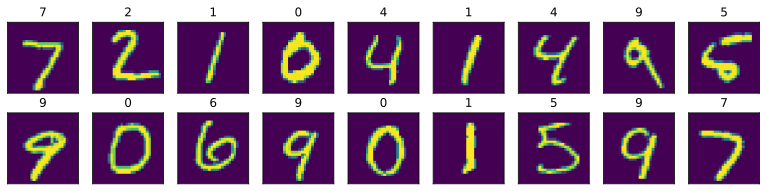

In [42]:
X, y = next(iter(test_iter))
fig.show_mnist_images(X.reshape(batch_size, 28, 28), 2, 9, titles=preData.get_mnist_labels(y))

## 编码映射方式

1. 
position -> random_vec,
value -> level_vec
pos * value

2. 
position -> random_vec
value * pos

### 通过 torch.nn 创建连接的方式


### 直接对数据集进行转换的方式

In [50]:
img_size = 28 * 28 # size of MNIST image
img_gray_val = 256 # maximum gray scale of MNIST image
num_class = 10 # number of classes inside MNIST dataset

print("Generating random projection...")
# proj = np.random.rand(d, img_size)

Generating random projection...


生成 position 即坐标位置的 IM 和每个像素值的 IM
初始化每个类的 AM

In [57]:
position_IM = item_memory(dim=dim, number=img_size, datatype=datatype)
grayscale_IM = item_memory(dim=dim, number=img_gray_val, datatype=datatype)     

AM = torch.zeros(size=(num_class, dim), dtype = torch.int16)
position_IM, grayscale_IM, AM = position_IM.to(device), grayscale_IM.to(device), AM.to(device)

In [ ]:
def encode(img, pos, val, dim):
    """
    Function
    ===
    Encode all the pixels in an image using pos&val IM.

    Parameter
    ----
    Reshape the size (1, 28, 28) to one-dimension
    Quantize the image data(represented in float [0, 1)) to [0, 256).
    
    Return
    ---

    """
    img = torch.round(img.reshape(-1) * 255).to(torch.int32)
    # img: 一个包含像素值的一维张量
    # pos: 一个包含位置向量的二维张量，shape 为 (img_size, vector_size)
    # val: 一个包含值向量的二维张量，shape 为 (num_values, vector_size)

    # 获取 img 中每个像素值对应的索引
    pos_indices = torch.arange(len(img)).unsqueeze(1)  # shape: (len(img), 1)
    pixel_indices = img.unsqueeze(1)  # shape: (len(img), 1)

    # 使用高级索引获取 pos 和 val 中对应的向量
    pos_vectors = pos[pos_indices]  # shape: (len(img), vector_size)
    val_vectors = val[pixel_indices]  # shape: (len(img), vector_size)

    # 对获取的向量进行异或操作
    img_hv = pos_vectors * val_vectors  # shape: (len(img), vector_size)

    img_hv = img_hv.sum(dim=0)
    # img_hv_prime = torch.zeros(size=(dim, ));
    # for pixel in range(len(img)):
    #     hv = pos[pixel] ^ val[img[pixel]]
    #     img_hv_prime += hv
    # assert not torch.equal(img_hv, img_hv_prime), print("vecotr fault")
    return img_hv[0]

def train(AM, X_train, Y_train, pos_IM, val_IM, dim):
    """
    Function
    ===
    For each image in the sample, encode the pixel and position, add to AM.
    """
    for img, label in zip(X_train, Y_train):
        AM[label] += encode(img, pos_IM, val_IM, dim=dim)

def predict(AM, img, pos_IM, val_IM, dim):
    """
    Function
    ===
    predict the class of the img according to memory
    First, encode the img to generate the query HV.
    Then compare the query HV with all the entry in AM and find the maximum index.
    """
    query_hv = encode(img, pos_IM, val_IM, dim)
    simi = F.cosine_similarity(query_hv.float(), AM.float())

    # max_simi = torch.max(simi)
    max_index = torch.argmax(simi).item()
    return max_index

def test(accuracy, AM, X_test, Y_test, pos_IM, val_IM, dim):
    """
    Function
    ===
    For each sample in the test dataset, predict the result.
    The overall result is converted to tensor and compared with label.
    """
    Y_pred = []
    for sample in X_test:
        Y_pred.append(predict(AM, sample, pos_IM, val_IM, dim))
    Y_pred = torch.tensor(Y_pred).to(device)
    accuracy.update(Y_test, Y_pred)

# X_train, Y_train = next(iter(train_iter))
# am = train(am=am, X_train=X_train, Y_train=Y_train,
#            pos_iM=position_iM, col_iM=grayscale_iM, dim=dim)

In [ ]:
for sample, label in test_iter:
    print(sample.dtype, label.dtype)
    sample = sample.to(device)
    print(sample.device)
    break

datatype:   0%|          | 0/40 [00:00<?, ?it/s]

torch.float32 torch.int64
cuda:0


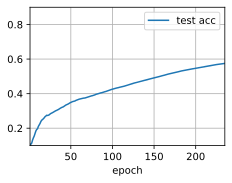

In [59]:
from tqdm import tqdm
import torchmetrics

test_accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_class).to(device)

num_epochs = len(train_iter)
animator = fig.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                    legend=['test acc'])
epoch = 0
for sample, label in train_iter:# tqdm(train_iter, desc="Training"):
    sample, label = sample.to(device), label.to(device)
    train(AM=AM, X_train=sample, Y_train=label,
               pos_IM=position_IM, val_IM=grayscale_IM, dim=dim)
    test(accuracy=test_accuracy, AM=AM, X_test=sample, Y_test=label,
         pos_IM=position_IM, val_IM=grayscale_IM, dim=dim)
    animator.add(epoch+1, (test_accuracy.compute().item()))
    fig.plt.show()
    epoch += 1
    # break


In [60]:
accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_class).to(device)

for sample, label in tqdm(test_iter, desc="Testing"):
    sample, label = sample.to(device), label.to(device)
    test(accuracy, AM, X_test=sample, Y_test=label,
         pos_IM=position_IM, val_IM=grayscale_IM, dim=dim)
    print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")
    # break

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Testing:   5%|▌         | 2/40 [00:01<00:17,  2.22it/s]

Testing accuracy of 75.000%
Testing accuracy of 72.656%


Testing:  10%|█         | 4/40 [00:01<00:08,  4.42it/s]

Testing accuracy of 70.833%
Testing accuracy of 70.996%


Testing:  15%|█▌        | 6/40 [00:01<00:05,  5.85it/s]

Testing accuracy of 69.844%
Testing accuracy of 70.117%


Testing:  20%|██        | 8/40 [00:01<00:04,  6.59it/s]

Testing accuracy of 69.866%
Testing accuracy of 69.922%


Testing:  25%|██▌       | 10/40 [00:02<00:04,  7.39it/s]

Testing accuracy of 69.444%
Testing accuracy of 69.570%


Testing:  30%|███       | 12/40 [00:02<00:03,  8.08it/s]

Testing accuracy of 69.922%
Testing accuracy of 69.954%


Testing:  35%|███▌      | 14/40 [00:02<00:03,  7.72it/s]

Testing accuracy of 69.952%
Testing accuracy of 69.643%


Testing:  40%|████      | 16/40 [00:02<00:02,  8.03it/s]

Testing accuracy of 69.349%
Testing accuracy of 69.507%


Testing:  45%|████▌     | 18/40 [00:03<00:02,  7.97it/s]

Testing accuracy of 69.600%
Testing accuracy of 69.488%


Testing:  50%|█████     | 20/40 [00:03<00:02,  8.14it/s]

Testing accuracy of 69.408%
Testing accuracy of 69.609%


Testing:  55%|█████▌    | 22/40 [00:03<00:02,  8.18it/s]

Testing accuracy of 70.406%
Testing accuracy of 70.792%


Testing:  60%|██████    | 24/40 [00:03<00:01,  8.03it/s]

Testing accuracy of 71.145%
Testing accuracy of 71.257%


Testing:  65%|██████▌   | 26/40 [00:03<00:01,  8.63it/s]

Testing accuracy of 71.922%
Testing accuracy of 72.145%


Testing:  70%|███████   | 28/40 [00:04<00:01,  8.54it/s]

Testing accuracy of 72.164%
Testing accuracy of 72.503%


Testing:  75%|███████▌  | 30/40 [00:04<00:01,  7.87it/s]

Testing accuracy of 72.724%
Testing accuracy of 72.669%


Testing:  80%|████████  | 32/40 [00:04<00:01,  7.97it/s]

Testing accuracy of 72.896%
Testing accuracy of 73.169%


Testing:  85%|████████▌ | 34/40 [00:04<00:00,  8.28it/s]

Testing accuracy of 73.319%
Testing accuracy of 73.702%


Testing:  90%|█████████ | 36/40 [00:05<00:00,  8.46it/s]

Testing accuracy of 74.297%
Testing accuracy of 74.436%


Testing:  95%|█████████▌| 38/40 [00:05<00:00,  8.29it/s]

Testing accuracy of 74.726%
Testing accuracy of 74.650%


Testing: 100%|██████████| 40/40 [00:05<00:00,  7.13it/s]

Testing accuracy of 74.449%
Testing accuracy of 74.450%


array([<Axes: title={'center': '7'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '1'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '9'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '7'}>,
       <Axes: title={'center': '0'}>, <Axes: title={'center': '6'}>,
       <Axes: title={'center': '9'}>, <Axes: title={'center': '0'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '3'}>,
       <Axes: title={'center': '4'}>, <Axes: title={'center': '7'}>],
      dtype=object)

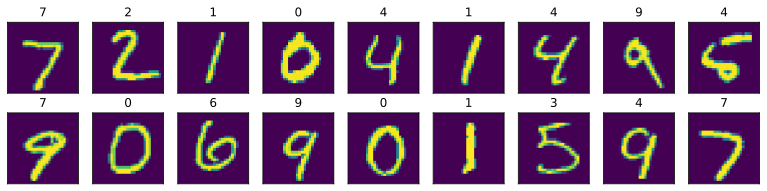

In [65]:
X, y = next(iter(test_iter))
Y_pred = []
for sample in X:
    Y_pred.append(predict(AM, sample, position_IM, grayscale_IM, dim))
Y_pred = torch.tensor(Y_pred)
fig.show_mnist_images(X.reshape(batch_size, 28, 28), 2, 9, titles=preData.get_mnist_labels(Y_pred))

在Python中，zip 函数用于将多个可迭代对象（如列表、元组、数组等）中的对应元素打包成一个个元组，然后返回由这些元组组成的迭代器。当你使用 for 循环遍历由 zip 创建的迭代器时，可以同时访问每个可迭代对象中的元素。